<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/ReviewTokoBaju_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import random
import requests
from io import StringIO

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ ------------------------

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\athallah\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\athallah\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [7]:
url = "https://github.com/farrelrassya/teachingMLDL/raw/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
s = requests.get(url).content
df = pd.read_csv(StringIO(s.decode('utf-8')))

In [8]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)


epochs = 10
num_words = 15000
maxlen = 200
batch_size = 256
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_prob = 0.15
lr = 0.001

review_col = 'Review Text'
rating_col = 'Rating'
df[review_col] = df[review_col].fillna("").astype(str)

# ==== Preprocessing ====
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()  # Ganti tokenizer nltk dengan split biasa
    return ' '.join([w for w in words if w not in stop_words])


df['processed_review'] = df[review_col].apply(preprocess_text)
df['sentiment'] = (df[rating_col] > 3).astype(int)

# ==== Build Vocab ====
def build_vocab(texts, max_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counts.most_common(max_words - 1))}
    vocab['<PAD>'] = 0
    return vocab

vocab = build_vocab(df['processed_review'].tolist(), num_words)
vocab_size = len(vocab)

def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]
    return sequence[:maxlen] + [0]*(maxlen - len(sequence))

df['sequence'] = df['processed_review'].apply(lambda x: text_to_sequence(x, vocab, maxlen))

# ==== Split Data ====
X = np.array(df['sequence'].tolist())
y = np.array(df['sentiment'].tolist())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_seed)

train_data = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

#RNN Model

In [9]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out).squeeze()

rnn_model = RNNModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

RNN Epoch 1: Train Loss=0.5402 Test Loss=0.5310
RNN Epoch 2: Train Loss=0.5357 Test Loss=0.5312
RNN Epoch 3: Train Loss=0.5350 Test Loss=0.5310
RNN Epoch 4: Train Loss=0.5336 Test Loss=0.5313
RNN Epoch 5: Train Loss=0.5340 Test Loss=0.5314
RNN Epoch 6: Train Loss=0.5335 Test Loss=0.5320
RNN Epoch 7: Train Loss=0.5333 Test Loss=0.5347
RNN Epoch 8: Train Loss=0.5339 Test Loss=0.5322
RNN Epoch 9: Train Loss=0.5333 Test Loss=0.5316
RNN Epoch 10: Train Loss=0.5339 Test Loss=0.5322


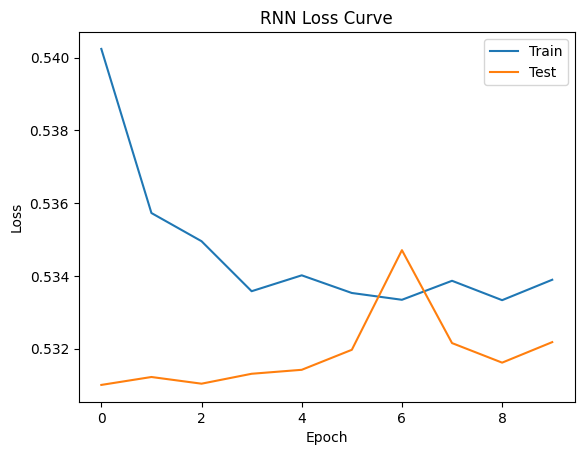

In [10]:
def train_model(model, name):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate
        model.eval()
        test_loss = 0
        preds, true = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                output = model(xb)
                loss = criterion(output, yb.float())
                test_loss += loss.item()
                preds += output.tolist()
                true += yb.tolist()

        test_losses.append(test_loss / len(test_loader))
        print(f"{name} Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f} Test Loss={test_losses[-1]:.4f}", flush=True)

    # Visualisasi Loss
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title(f'{name} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return preds, true

rnn_preds, rnn_true = train_model(rnn_model, "RNN")


RNN Evaluation:
Accuracy  : 0.7752
Precision : 0.7752
Recall    : 1.0000
F1 Score  : 0.8734
AUC       : 0.5000


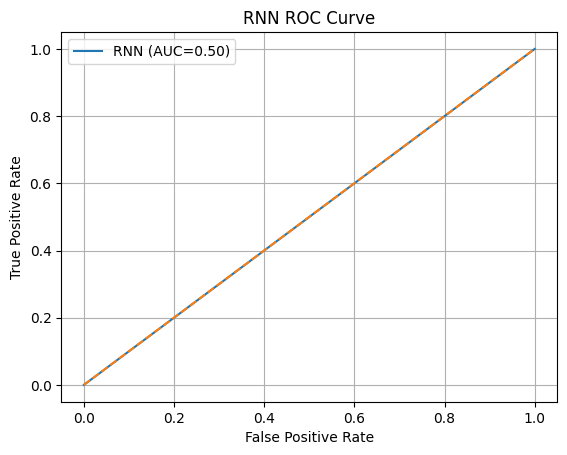

In [11]:
def evaluate_model(preds, true, name):
    y_pred = [1 if p >= 0.5 else 0 for p in preds]
    acc = accuracy_score(true, y_pred)
    prec = precision_score(true, y_pred)
    rec = recall_score(true, y_pred)
    f1 = f1_score(true, y_pred)
    auc = roc_auc_score(true, preds)
    fpr, tpr, _ = roc_curve(true, preds)

    print(f"\n{name} Evaluation:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"AUC       : {auc:.4f}")

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_model(rnn_preds, rnn_true, "RNN")


#LSTM Model


In [12]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out).squeeze()

lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)


LSTM Epoch 1: Train Loss=0.5378 Test Loss=0.5331
LSTM Epoch 2: Train Loss=0.5345 Test Loss=0.5312
LSTM Epoch 3: Train Loss=0.5330 Test Loss=0.5311
LSTM Epoch 4: Train Loss=0.5332 Test Loss=0.5312
LSTM Epoch 5: Train Loss=0.5336 Test Loss=0.5310
LSTM Epoch 6: Train Loss=0.5330 Test Loss=0.5313
LSTM Epoch 7: Train Loss=0.5332 Test Loss=0.5310
LSTM Epoch 8: Train Loss=0.5326 Test Loss=0.5326
LSTM Epoch 9: Train Loss=0.5332 Test Loss=0.5311
LSTM Epoch 10: Train Loss=0.5333 Test Loss=0.5332


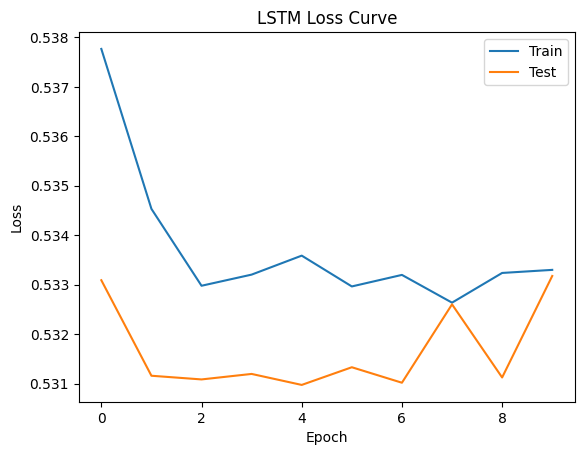

In [13]:
def train_model(model, name):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate
        model.eval()
        test_loss = 0
        preds, true = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                output = model(xb)
                loss = criterion(output, yb.float())
                test_loss += loss.item()
                preds += output.tolist()
                true += yb.tolist()

        test_losses.append(test_loss / len(test_loader))
        print(f"{name} Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f} Test Loss={test_losses[-1]:.4f}", flush=True)

    # Visualisasi Loss
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title(f'{name} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return preds, true

lstm_preds, lstm_true = train_model(lstm_model, "LSTM")


LSTM Evaluation:
Accuracy  : 0.7752
Precision : 0.7752
Recall    : 1.0000
F1 Score  : 0.8734
AUC       : 0.5000


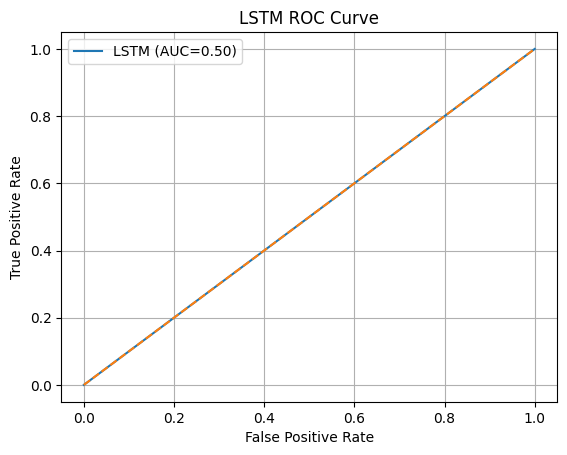

In [14]:
def evaluate_model(preds, true, name):
    y_pred = [1 if p >= 0.5 else 0 for p in preds]
    acc = accuracy_score(true, y_pred)
    prec = precision_score(true, y_pred)
    rec = recall_score(true, y_pred)
    f1 = f1_score(true, y_pred)
    auc = roc_auc_score(true, preds)
    fpr, tpr, _ = roc_curve(true, preds)

    print(f"\n{name} Evaluation:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"AUC       : {auc:.4f}")

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_model(lstm_preds, lstm_true, "LSTM")


#GRU Model

In [15]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out).squeeze()

gru_model = GRUModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

GRU Epoch 1: Train Loss=0.5364 Test Loss=0.5310
GRU Epoch 2: Train Loss=0.5334 Test Loss=0.5353
GRU Epoch 3: Train Loss=0.5343 Test Loss=0.5312
GRU Epoch 4: Train Loss=0.5341 Test Loss=0.5269
GRU Epoch 5: Train Loss=0.4390 Test Loss=0.3597
GRU Epoch 6: Train Loss=0.3009 Test Loss=0.3339
GRU Epoch 7: Train Loss=0.2429 Test Loss=0.3190
GRU Epoch 8: Train Loss=0.1889 Test Loss=0.3370
GRU Epoch 9: Train Loss=0.1393 Test Loss=0.4086
GRU Epoch 10: Train Loss=0.0899 Test Loss=0.4941


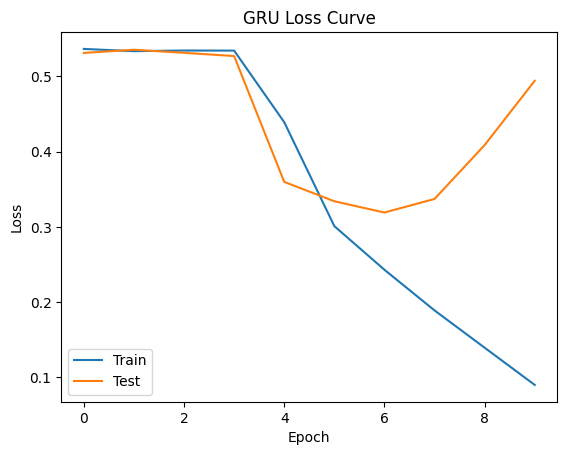

In [16]:
def train_model(model, name):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate
        model.eval()
        test_loss = 0
        preds, true = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                output = model(xb)
                loss = criterion(output, yb.float())
                test_loss += loss.item()
                preds += output.tolist()
                true += yb.tolist()

        test_losses.append(test_loss / len(test_loader))
        print(f"{name} Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f} Test Loss={test_losses[-1]:.4f}", flush=True)

    # Visualisasi Loss
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title(f'{name} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return preds, true

gru_preds, gru_true = train_model(gru_model, "GRU")


GRU Evaluation:
Accuracy  : 0.8631
Precision : 0.8904
Recall    : 0.9390
F1 Score  : 0.9141
AUC       : 0.8879


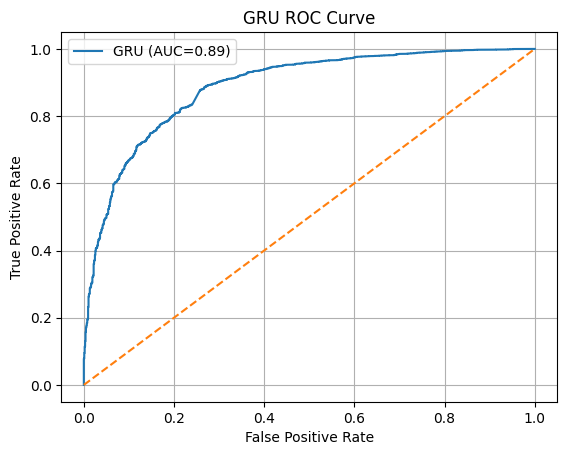

In [17]:
def evaluate_model(preds, true, name):
    y_pred = [1 if p >= 0.5 else 0 for p in preds]
    acc = accuracy_score(true, y_pred)
    prec = precision_score(true, y_pred)
    rec = recall_score(true, y_pred)
    f1 = f1_score(true, y_pred)
    auc = roc_auc_score(true, preds)
    fpr, tpr, _ = roc_curve(true, preds)

    print(f"\n{name} Evaluation:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"AUC       : {auc:.4f}")

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_model(gru_preds, gru_true, "GRU")

##  Persamaan Matematika

### 1. RNN (Recurrent Neural Network)

$$
h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

$$
y_t = W_{hy}h_t + b_y
$$

---

### 2. LSTM (Long Short-Term Memory)

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$

$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

$$
C_t = f_t \ast C_{t-1} + i_t \ast \tilde{C}_t
$$

$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$

$$
h_t = o_t \ast \tanh(C_t)
$$

---

### 3. GRU (Gated Recurrent Unit)

$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t])
$$

$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t])
$$

$$
\tilde{h}_t = \tanh(W \cdot [r_t \ast h_{t-1}, x_t])
$$

$$
h_t = (1 - z_t) \ast h_{t-1} + z_t \ast \tilde{h}_t
$$

---

##  Analisis Hasil Evaluasi

### RNN dan LSTM

- **Accuracy**: 0.7752  
- **Precision**: 0.7752  
- **Recall**: 1.0000  
- **F1 Score**: 0.8734  
- **AUC**: 0.5000  

**Analisis**:
- Baik RNN maupun LSTM memiliki **recall sempurna (1.0000)**, artinya semua data positif terklasifikasi dengan benar.
- **Precision rendah (0.7752)** menunjukkan banyak false positive.
- **F1 score tinggi (0.8734)** menunjukkan keseimbangan cukup baik antara precision dan recall.
- **AUC = 0.5000** menunjukkan model tidak mampu membedakan kelas secara baik, mirip performa acak.
- LSTM tidak menunjukkan keunggulan dibanding RNN di dataset ini.

---

### GRU

- **Accuracy**: 0.8631  
- **Precision**: 0.8904  
- **Recall**: 0.9390  
- **F1 Score**: 0.9141  
- **AUC**: 0.8879  

**Analisis**:
- GRU memberikan hasil terbaik di seluruh metrik.
- Kombinasi **precision dan recall tinggi** menghasilkan **F1 score sangat baik (0.9141)**.
- **AUC tinggi (0.8879)** menunjukkan performa klasifikasi sangat baik.
- GRU lebih efisien dibanding LSTM dan cocok untuk dataset ini.

---
